# Recommandation system:

A **recommendation system** with embeddings is a type of recommender system that uses vector representations (embeddings) to model users and items (like products, movies, songs) in a shared space, so that similar users and items are close together in that space.

## 🔍 How a Sentence Becomes a Vector (Text Embedding) — Full Breakdown

The goal of a text embedding model is to transform a sentence like "Harry Potter is a wizard." into a high-dimensional numerical vector (e.g., a list of 1536 numbers) that a computer can understand, compare, classify, or visualize.
### 🔹 Step 1: Tokenization

The input sentence is first broken down into meaningful units called tokens. These tokens are usually words or subwords.
Example:

"Harry Potter is a wizard." → ["Harry", " Potter", " is", " a", " wizard", "."]

Each token is then converted into a unique integer ID using a predefined vocabulary learned during training. For example:

["Harry", " Potter", " is", " a", " wizard", "."] → [7234, 4812, 318, 257, 10394, 13]

### 🔹 Step 2: Token Embedding (Lookup)

Each token ID is then used to retrieve a vector from a large embedding matrix E of size (vocabulary_size × embedding_dim) — e.g., (50,000 × 1536).
For example, token ID 7234 retrieves the 7234th row of the matrix, giving a dense vector of 1536 real numbers representing the token "Harry".

So the sentence becomes a sequence of vectors, one for each word.
### 🔹 Step 3: Contextual Encoding (Transformer)

These token vectors are then passed through a Transformer neural network (the same architecture used in GPT).
The core idea is self-attention: each word "looks at" the others and adjusts its vector based on the context.

Mathematically:

    Each token computes attention scores with all other tokens.

    These scores (via dot products + softmax) determine how much influence each word has.

    Vectors are updated using these weighted combinations.

    The output represents context-aware word vectors, which understand sentence meaning (e.g., "wizard" is related to "Harry Potter").

Multiple layers of attention, feedforward layers, normalization, and residuals further refine this understanding.
### 🔹 Step 4: Pooling — Creating a Sentence Vector

After processing, we have a set of contextualized word vectors (still one per word).
To represent the whole sentence as a single vector, we apply pooling, such as:

    Mean pooling: average of all word vectors

    CLS pooling: take only a special [CLS] token’s vector (like in BERT)

    Weighted sum: based on attention or learned weights

Example with mean pooling:

sentence_vector = mean([V1, V2, V3, V4, V5, V6])

The result is a single 1536-dimensional vector representing the full sentence.
### 🔹 Step 5: Using the Embedding

Now that we have a numerical vector for the sentence, we can:

    📏 Compare sentences (cosine similarity → close to 1 means similar)

    🔍 Search semantically (find similar texts)

    🧠 Cluster documents (e.g., with HDBSCAN or K-means)

    📉 Reduce dimensions for 2D/3D visualization (PCA, t-SNE, LLE)

    🔄 Feed into other ML models for classification, recommendation, etc.
    
## ✅ Final Summary of the Steps:
Step	Name	Description
1	Tokenization	Break sentence into tokens → convert to IDs
2	Embedding Lookup	Convert IDs into dense vectors
3	Transformer Encoding	Understand meaning via self-attention
4	Pooling	Reduce to one sentence vector
5	Usage	Compare, search, cluster, visualize...

This process is what happens behind the scenes when you run:

client.embeddings.create(model="text-embedding-3-small", input="Harry Potter is a wizard.")


In [770]:
from openai import OpenAI
from scipy.spatial import distance
from tqdm import trange, tqdm
from sklearn.cluster import HDBSCAN
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import openai
import warnings
warnings.filterwarnings('ignore')

#Api Key:
API_KEY = "sk-proj......."

# Import Netflix movies:
netflix_movies = [
    # 🔫 Sci-Fi / Action
    {
        "title": "Terminator 2: Judgment Day",
        "short_description": "A reprogrammed Terminator protects the future savior of humanity from a new deadly machine.",
        "category": "Sci-Fi / Action"
    },
    {
        "title": "Inception",
        "short_description": "A skilled thief enters people's dreams to steal secrets but must pull off the ultimate mind-heist.",
        "category": "Sci-Fi / Thriller"
    },
    {
        "title": "The Matrix",
        "short_description": "A hacker discovers reality is a simulation and joins a rebellion against the machines.",
        "category": "Sci-Fi / Action"
    },
    {
        "title": "Blade Runner 2049",
        "short_description": "A new blade runner unearths a long-buried secret that could reshape society.",
        "category": "Sci-Fi / Thriller"
    },
    {
        "title": "The Fifth Element",
        "short_description": "In a futuristic world, a cab driver becomes central to the search for a cosmic weapon to save Earth.",
        "category": "Sci-Fi / Action"
    },

    # 🦸 Superhero (Marvel/DC)
    {
        "title": "Iron Man",
        "short_description": "Tony Stark builds a high-tech suit to escape captivity and begins a heroic journey.",
        "category": "Superhero (Marvel)"
    },
    {
        "title": "The Dark Knight",
        "short_description": "Batman faces off against the Joker in a gritty battle for Gotham’s soul.",
        "category": "Superhero (DC)"
    },
    {
        "title": "Avengers: Endgame",
        "short_description": "The Avengers fight to undo the destruction caused by Thanos across the universe.",
        "category": "Superhero (Marvel)"
    },
    {
        "title": "Spider-Man: Into the Spider-Verse",
        "short_description": "Teenager Miles Morales becomes Spider-Man and teams up with other Spider-People from different dimensions.",
        "category": "Superhero (Animation)"
    },
    {
        "title": "Black Panther",
        "short_description": "T'Challa returns home to the isolated, technologically advanced African nation of Wakanda to take the throne.",
        "category": "Superhero (Marvel)"
    },

    # 🎥 Spy / Action
    {
        "title": "Mission: Impossible – Fallout",
        "short_description": "Ethan Hunt races against time after a mission goes wrong, risking global disaster.",
        "category": "Spy / Action"
    },
    {
        "title": "Skyfall",
        "short_description": "James Bond uncovers secrets from M’s past while stopping a cyberterrorist.",
        "category": "Spy / Thriller"
    },
    {
        "title": "The Bourne Identity",
        "short_description": "An amnesiac spy fights to discover who he really is while being hunted.",
        "category": "Spy / Thriller"
    },
    {
        "title": "Casino Royale",
        "short_description": "James Bond's first mission as 007 leads him to a high-stakes poker game in Montenegro.",
        "category": "Spy / Action"
    },
    {
        "title": "Tinker Tailor Soldier Spy",
        "short_description": "In the 1970s, espionage veteran George Smiley is tasked with uncovering a Soviet agent within MI6.",
        "category": "Spy / Thriller"
    },

    # 🧙 Fantasy / Adventure
    {
        "title": "The Lord of the Rings: The Fellowship of the Ring",
        "short_description": "A hobbit begins a perilous journey to destroy a powerful ring.",
        "category": "Fantasy / Adventure"
    },
    {
        "title": "Harry Potter and the Sorcerer’s Stone",
        "short_description": "A young wizard begins his magical education at Hogwarts.",
        "category": "Fantasy / Family"
    },
    {
        "title": "Pirates of the Caribbean: The Curse of the Black Pearl",
        "short_description": "Captain Jack Sparrow races to recover a cursed treasure.",
        "category": "Fantasy / Action"
    },
    {
        "title": "The Chronicles of Narnia: The Lion, the Witch and the Wardrobe",
        "short_description": "Four siblings discover a magical land and join the fight against an evil queen.",
        "category": "Fantasy / Adventure"
    },
    {
        "title": "Stardust",
        "short_description": "A young man ventures into a magical realm to retrieve a fallen star for his beloved.",
        "category": "Fantasy / Adventure"
    },

    # 😂 Comedy
    {
        "title": "The Mask",
        "short_description": "A timid man finds a magical mask that turns him into a manic superhero.",
        "category": "Comedy / Superhero"
    },
    {
        "title": "Home Alone",
        "short_description": "A clever kid defends his house from burglars while left alone during Christmas.",
        "category": "Comedy / Family"
    },
    {
        "title": "The Hangover",
        "short_description": "A bachelor party in Vegas turns chaotic after the groom goes missing.",
        "category": "Comedy / Adult"
    },
    {
        "title": "Superbad",
        "short_description": "Two high school friends try to enjoy their last days before graduation.",
        "category": "Comedy"
    },
    {
        "title": "Anchorman: The Legend of Ron Burgundy",
        "short_description": "A chauvinistic news anchor faces a new female co-anchor in 1970s San Diego.",
        "category": "Comedy"
    },

    # 💘 Romance / Drama
    {
        "title": "Titanic",
        "short_description": "A rich girl and a poor artist fall in love aboard the doomed ship.",
        "category": "Romance / Drama"
    },
    {
        "title": "The Notebook",
        "short_description": "A young couple's love story is told through the years against all odds.",
        "category": "Romance / Drama"
    },
    {
        "title": "La La Land",
        "short_description": "An actress and a musician fall in love while chasing their dreams in LA.",
        "category": "Romance / Musical"
    },
    {
        "title": "Pride and Prejudice",
        "short_description": "An Englishwoman navigates societal expectations and personal desires in the 19th century.",
        "category": "Romance / Drama"
    },
    {
        "title": "Eternal Sunshine of the Spotless Mind",
        "short_description": "After a painful breakup, a couple undergoes a procedure to erase memories of each other.",
        "category": "Romance / Sci-Fi"
    },

    # 😱 Horror
    {
        "title": "Get Out",
        "short_description": "A Black man uncovers a terrifying secret while visiting his white girlfriend’s family.",
        "category": "Horror / Thriller"
}]


In [771]:
#Create a dataframe:
movies = pd.DataFrame(data=netflix_movies)
movies.head(3)

,title,short_description,category
0,Terminator 2: Judgment Day,A reprogrammed Terminator protects the future ...,Sci-Fi / Action
1,Inception,A skilled thief enters people's dreams to stea...,Sci-Fi / Thriller
2,The Matrix,A hacker discovers reality is a simulation and...,Sci-Fi / Action


In [772]:
def CreateEmbeddingVectors():
    
    #Retrieving the short_description for each movie:
    movie_description = [movie['short_description'] for movie in netflix_movies]
    #Create client:
    client = openai.OpenAI(api_key=API_KEY,  organization=None, project= None, base_url= None,
    websocket_base_url= None, timeout= 60*5, max_retries= int(2), default_headers=None, default_query= None, http_client= None
                        )
    
    #Preparing the response:
    response = client.embeddings.create(
        model="text-embedding-3-small", #model embedding
        input=movie_description
    )
    
    #Add vector embeddings for each movie in the dict:
    for i, movie in enumerate(netflix_movies):
        movie['embedding'] = response.model_dump()['data'][i]['embedding']

    #Storing titles, categories & embeddings vectors in a list:
    titles = [movie['title'] for movie in netflix_movies]
    categories = [movie['category'] for movie in netflix_movies]
    descriptions = [movie['short_description'] for movie in netflix_movies]
    embeddings = [movie['embedding'] for movie in netflix_movies]
    
    #Model LLE (Dimensionality reduction technique):
    lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
    embeddings_2d = lle.fit_transform(embeddings)

    #Plot:
    plt.style.use('seaborn-v0_8-ticks')
    plt.figure(figsize=(18,8))
    plt.subplot(1,3,1)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], edgecolors='black', color="lightblue")
    plt.title("Projection 2D with LLE - Category")
    for i, category in enumerate(categories):
        plt.annotate(category, (embeddings_2d[i,0], embeddings_2d[i,1]), fontsize=10, ha='center')
    
    plt.subplot(1,3,2)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], edgecolors='black', color="lightblue")
    plt.title("Projection 2D  with LLE - Titles")
    for i, title in enumerate(titles):
        plt.annotate(title, (embeddings_2d[i,0], embeddings_2d[i,1]), fontsize=10, ha='center')
    
    #HDBSCAN for clustering:
    hdbscan=HDBSCAN(min_cluster_size=4)
    hdbscan.fit(embeddings_2d)
    #Convert Array in DataFrame and add labels from HDBSCAN:
    embeddings_2d = pd.DataFrame(data=embeddings_2d, columns={"PC1":"0", "PC2":"1"})
    cluster_plot = pd.concat([embeddings_2d, pd.DataFrame(data=hdbscan.labels_)], axis=1)
    cluster_plot.rename(columns={0: "labels"}, inplace=True)
    
    #Plot:
    plt.subplot(1,3,3)
    plt.scatter(cluster_plot["PC1"], cluster_plot["PC2"], edgecolors='black', c=cluster_plot["labels"], cmap='ocean')
    plt.title("Clustering with HDBSCAN")

    plt.tight_layout()
    plt.show()

    text= "James Bond"
    client=openai.OpenAI(api_key=API_KEY)
    response=client.embeddings.create(model='text-embedding-3-small', input=text)
    response_dict = response.model_dump()
    #return response_dict['data'][0]['embedding']
    
    create_embedding(text)

    search_text=text
    search_embedding = create_embedding(search_text)
    #article embeddings:
    distances = []
    for movie in netflix_movies:
        dist = distance.cosine(search_embedding, movie['embedding'])
        distances.append(dist)
    print(distances)

    min_dist_ind = np.argmin(distances) #Return index for which the distance is the smallest between computer and the headlines.
    return netflix_movies[min_dist_ind]['title']
    return distances


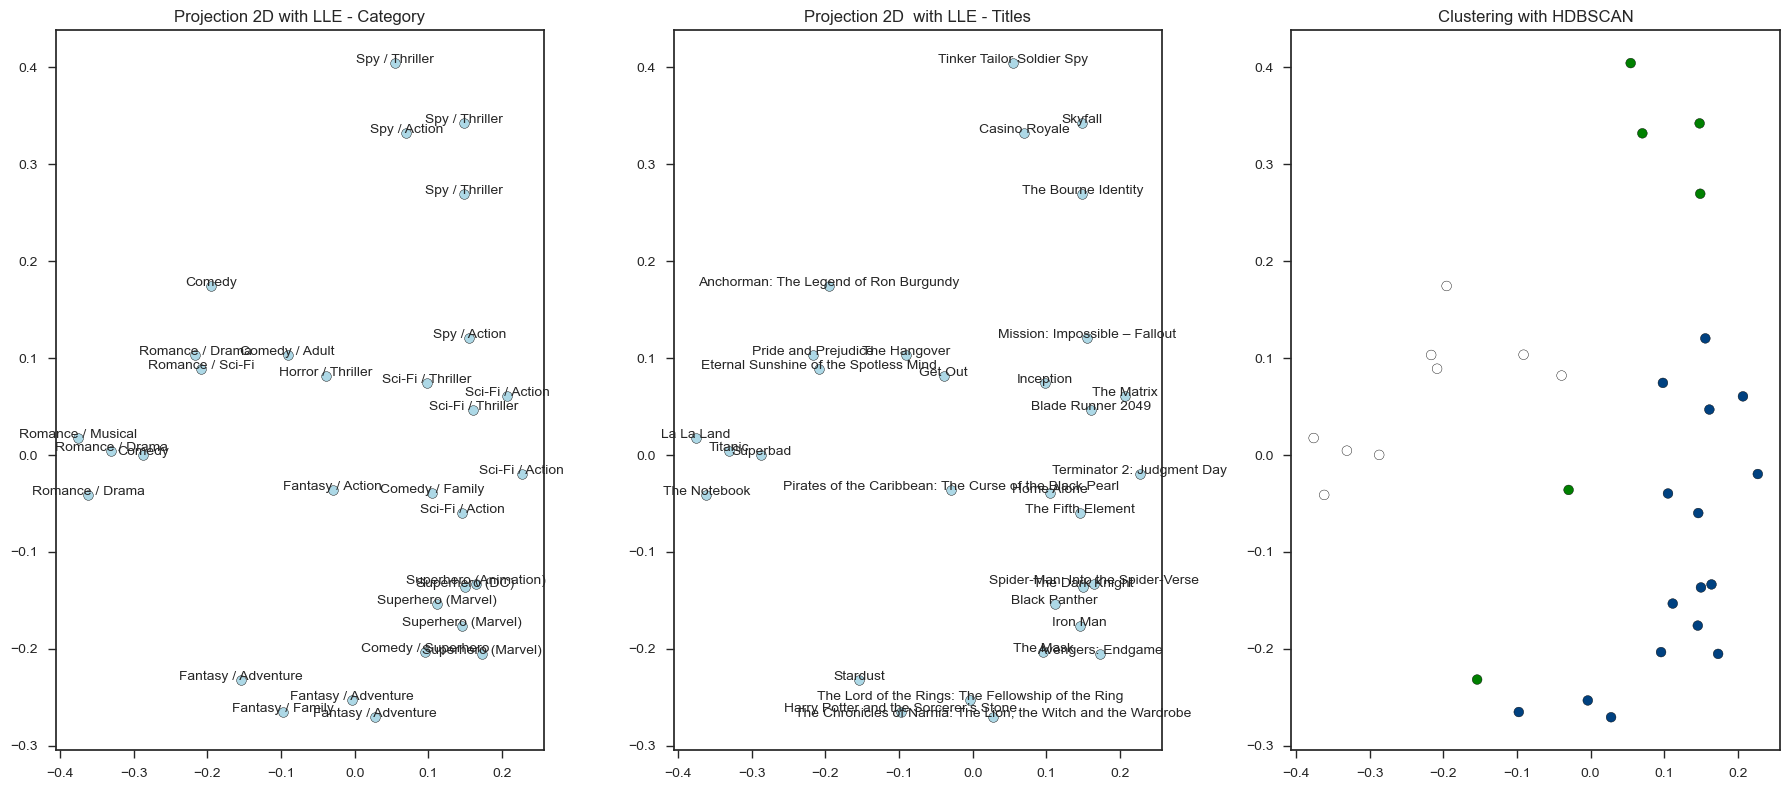

[0.792081694703629, 0.765627409930931, 0.7612255962861987, 0.7555343447043945, 0.7138152431761595, 0.6624683296108926, 0.8046179627419294, 0.8191684785130082, 0.7822473365235991, 0.8150834326759386, 0.6251850123766343, 0.3850851733152175, 0.5475055903293735, 0.39344812563263265, 0.5752966584748307, 0.7231959002031093, 0.8253796865913241, 0.6955233303279209, 0.8647605854037115, 0.7998371378287102, 0.7282084214065214, 0.8023311392829378, 0.7981035922465165, 0.8276123398664595, 0.8627004030026035, 0.8375086324444777, 0.8703433199898122, 0.8190861964625087, 0.7648750422609036, 0.8874042556123835, 0.8333221252435837]


'Skyfall'

In [773]:
CreateEmbeddingVectors()

## Video Games: What game should I try next?

In [775]:
video_games = [
    {"title": "Minecraft", "developer": "Mojang", "short_description": "Sandbox world-building game with endless creativity."},
    {"title": "Grand Theft Auto V", "developer": "Rockstar Games", "short_description": "Open-world crime game in Los Santos."},
    {"title": "Tetris", "developer": "Alexey Pajitnov", "short_description": "Iconic tile-matching puzzle game."},
    {"title": "The Legend of Zelda: Breath of the Wild", "developer": "Nintendo", "short_description": "Open-world adventure across Hyrule."},
    {"title": "Super Mario Bros.", "developer": "Nintendo", "short_description": "Platformer that launched a gaming icon."},
    {"title": "Pokémon Red/Blue/Yellow", "developer": "Game Freak", "short_description": "Train Pokémon and become champion."},
    {"title": "Wii Sports", "developer": "Nintendo", "short_description": "Motion-controlled sports mini-games."},
    {"title": "Super Mario World", "developer": "Nintendo", "short_description": "Mario’s SNES adventure with Yoshi."},
    {"title": "Skyrim", "developer": "Bethesda", "short_description": "Epic RPG in a vast fantasy world."},
    {"title": "The Witcher 3: Wild Hunt", "developer": "CD Projekt Red", "short_description": "Monster hunting and deep storytelling."},
    {"title": "Super Smash Bros. Ultimate", "developer": "Nintendo", "short_description": "Crossover fighting game of all-stars."},
    {"title": "Call of Duty: Modern Warfare", "developer": "Infinity Ward", "short_description": "Modern military FPS."},
    {"title": "Animal Crossing: New Horizons", "developer": "Nintendo", "short_description": "Peaceful island life simulator."},
    {"title": "Red Dead Redemption 2", "developer": "Rockstar Games", "short_description": "Western outlaw story in open world."},
    {"title": "Fortnite", "developer": "Epic Games", "short_description": "Battle royale with building mechanics."},
    {"title": "Pokémon Gold/Silver", "developer": "Game Freak", "short_description": "Second-gen Pokémon adventure."},
    {"title": "The Sims", "developer": "Maxis", "short_description": "Life simulation game."},
    {"title": "World of Warcraft", "developer": "Blizzard", "short_description": "Massively multiplayer online RPG."},
    {"title": "GTA: San Andreas", "developer": "Rockstar Games", "short_description": "Open-world crime and freedom."},
    {"title": "Minecraft Dungeons", "developer": "Mojang", "short_description": "Dungeon crawler in Minecraft world."},
    {"title": "Overwatch", "developer": "Blizzard", "short_description": "Hero-based team shooter."},
    {"title": "Half-Life 2", "developer": "Valve", "short_description": "Sci-fi FPS with physics gameplay."},
    {"title": "Final Fantasy VII", "developer": "Square Enix", "short_description": "Classic JRPG with Cloud and Sephiroth."},
    {"title": "Metal Gear Solid", "developer": "Konami", "short_description": "Stealth action with deep story."},
    {"title": "Diablo II", "developer": "Blizzard", "short_description": "Action RPG loot fest."},
    {"title": "Street Fighter II", "developer": "Capcom", "short_description": "Iconic competitive fighting game."},
    {"title": "DOOM (1993)", "developer": "id Software", "short_description": "Fast-paced demon-slaying shooter."},
    {"title": "Halo: Combat Evolved", "developer": "Bungie", "short_description": "Sci-fi FPS that defined Xbox."},
    {"title": "Uncharted 2: Among Thieves", "developer": "Naughty Dog", "short_description": "Cinematic treasure-hunting action."},
    {"title": "Resident Evil 4", "developer": "Capcom", "short_description": "Survival horror meets action gameplay."},
    {"title": "Mass Effect 2", "developer": "BioWare", "short_description": "Sci-fi RPG with choices and squad."},
    {"title": "Stardew Valley", "developer": "ConcernedApe", "short_description": "Farming, relationships, and exploration."},
    {"title": "Tony Hawk’s Pro Skater", "developer": "Neversoft", "short_description": "Skateboarding arcade-style action."},
    {"title": "Call of Duty 4: Modern Warfare", "developer": "Infinity Ward", "short_description": "Defined modern military FPS."},
    {"title": "Fallout 3", "developer": "Bethesda", "short_description": "Post-apocalyptic RPG shooter."},
    {"title": "Mario Kart 64", "developer": "Nintendo", "short_description": "Iconic kart racing game."},
    {"title": "Baldur’s Gate 3", "developer": "Larian Studios", "short_description": "Deep D&D-inspired RPG."},
    {"title": "Madden NFL 2004", "developer": "EA Sports", "short_description": "American football simulation."},
    {"title": "Celeste", "developer": "Matt Makes Games", "short_description": "Challenging platformer with story."},
    {"title": "Batman: Arkham City", "developer": "Rocksteady", "short_description": "Open-world superhero action."},
    {"title": "Chrono Trigger", "developer": "Square", "short_description": "Time-traveling JRPG masterpiece."},
    {"title": "Shadow of the Colossus", "developer": "Team Ico", "short_description": "Boss-fighting adventure in a vast land."},
    {"title": "Pokémon Sword/Shield", "developer": "Game Freak", "short_description": "Pokémon adventure on Nintendo Switch."},
    {"title": "Hollow Knight", "developer": "Team Cherry", "short_description": "Hand-drawn Metroidvania adventure."},
    {"title": "NBA 2K11", "developer": "Visual Concepts", "short_description": "Basketball simulation with MJ mode."},
    {"title": "Ms. Pac-Man", "developer": "Namco", "short_description": "Sequel to the arcade classic."},
    {"title": "Counter-Strike", "developer": "Valve", "short_description": "Team-based tactical FPS."},
    {"title": "Wii Sports Resort", "developer": "Nintendo", "short_description": "Sequel with new sports and motion."},
    {"title": "Call of Duty: Black Ops II", "developer": "Treyarch", "short_description": "Cold War-era FPS with branching story."},
    {"title": "New Super Mario Bros.", "developer": "Nintendo", "short_description": "Modern 2D Mario platformer."}
]


In [824]:
def CreateEmbeddingVectorsGame(search_game):
    
    #Retrieving the short_description for each movie:
    game_description = [game['short_description'] for game in video_games]
    #Create client:
    client = openai.OpenAI(api_key=API_KEY,  organization=None, project= None, base_url= None,
    websocket_base_url= None, timeout= 60*5, max_retries= int(2), default_headers=None, default_query= None, http_client= None
                        )
    
    #Preparing the response:
    response = client.embeddings.create(
        model="text-embedding-3-small", #model embedding
        input=game_description
    )
    
    #Add vector embeddings for each movie in the dict:
    for i, game in enumerate(video_games):
        game['embedding'] = response.model_dump()['data'][i]['embedding']

    #Storing titles, categories & embeddings vectors in a list:
    titles = [game['title'] for game in video_games]
    descriptions = [game['short_description'] for game in video_games]
    developers = [game['developer'] for game in video_games]
    embeddings = [game['embedding'] for game in video_games]
    
    #Model LLE (Dimensionality reduction technique):
    lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
    embeddings_2d = lle.fit_transform(embeddings)

    #Plot:
    plt.style.use('seaborn-v0_8-ticks')
    plt.figure(figsize=(16,12))
    plt.subplot(1,3,1)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], edgecolors='black', color="lightblue")
    plt.title("Projection 2D with LLE - Developers")
    for i, dev in enumerate(developers):
        plt.annotate(dev, (embeddings_2d[i,0], embeddings_2d[i,1]), fontsize=10, ha='center')
    
    plt.subplot(1,3,2)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], edgecolors='black', color="lightblue")
    plt.title("Projection 2D  with LLE - Games")
    for i, title in enumerate(titles):
        plt.annotate(title, (embeddings_2d[i,0], embeddings_2d[i,1]), fontsize=10, ha='center')
    
    #HDBSCAN for clustering:
    hdbscan=HDBSCAN(min_cluster_size=4)
    hdbscan.fit(embeddings_2d)
    #Convert Array in DataFrame and add labels from HDBSCAN:
    embeddings_2d = pd.DataFrame(data=embeddings_2d, columns={"PC1":"0", "PC2":"1"})
    cluster_plot = pd.concat([embeddings_2d, pd.DataFrame(data=hdbscan.labels_)], axis=1)
    cluster_plot.rename(columns={0: "labels"}, inplace=True)
    
    #Plot:
    plt.subplot(1,3,3)
    plt.scatter(cluster_plot["PC1"], cluster_plot["PC2"], edgecolors='black', c=cluster_plot["labels"], cmap='ocean')
    plt.title("Clustering with HDBSCAN")

    plt.tight_layout()
    plt.show()

    
    text= search_game #Recommandation: 
    client=openai.OpenAI(api_key=API_KEY)
    response=client.embeddings.create(model='text-embedding-3-small', input=text)
    response_dict = response.model_dump()
    #return response_dict['data'][0]['embedding']
    
    create_embedding(text)

    search_text=text
    search_embedding = create_embedding(search_text)
    #article embeddings:
    distances = []
    for game in video_games:
        dist = distance.cosine(search_embedding, game['embedding'])
        distances.append(dist)
    #print(distances)

    min_dist_ind = np.argmin(distances) #Return index for which the distance is the smallest between computer and the headlines.
    print(f"\nRecommandation:")
    print("--------------------")
    return video_games[min_dist_ind]['title']
    


Share a game you enjoy, and I’ll recommend another with a similar vibe Mafia II


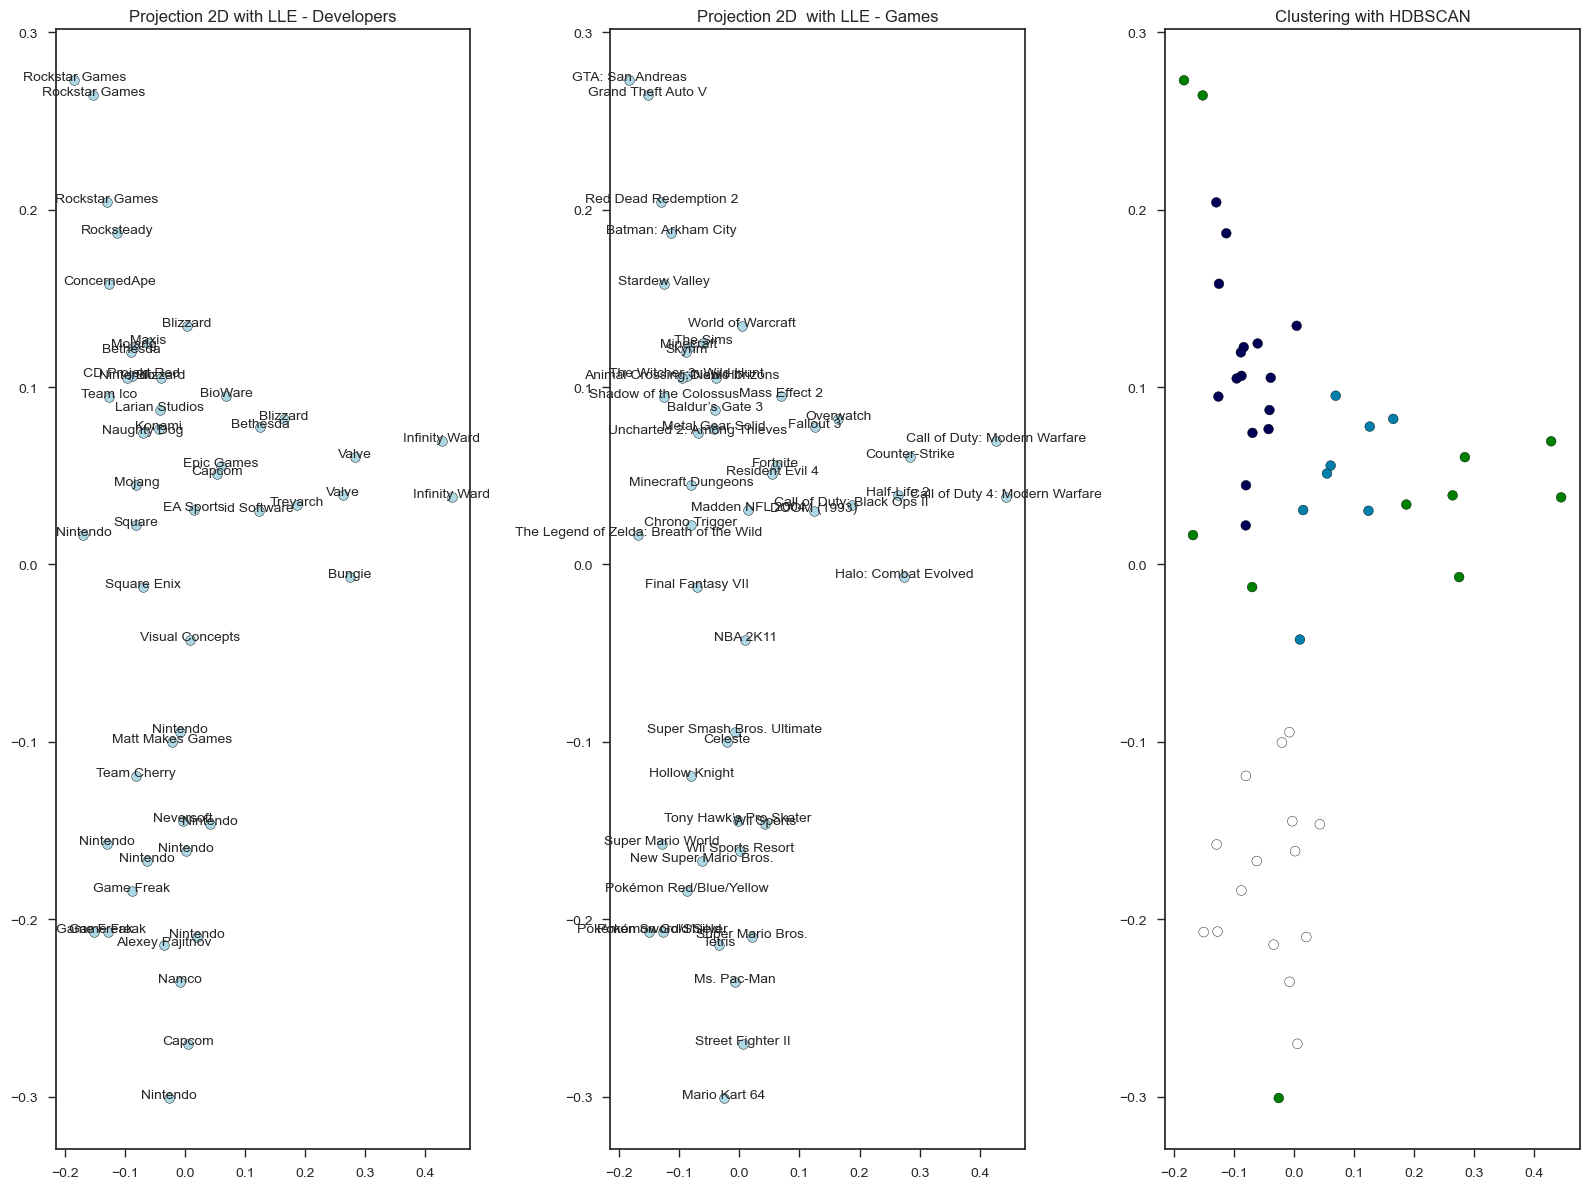


Recommandation:
--------------------


'Grand Theft Auto V'

In [852]:
#Help me find a game similar to :
input_game = input('Share a game you enjoy, and I’ll recommend another with a similar vibe')
CreateEmbeddingVectorsGame(input_game)